# Make a simple FeedForward network for the bus data

## Initialization

In [79]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

## Import data using the MoviaBusDataset

In [80]:
prev_timesteps = 6
prediction_steps = 1

train = MoviaBusDataset('../data/train', interpolation=True, prev_timesteps=prev_timesteps, max_future_time_steps=prediction_steps, timeofday = True)
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=prev_timesteps, max_future_time_steps=prediction_steps, timeofday = True)

train.normalize()
test.normalize(train.mean, train.std)

In [81]:
train_DL = DataLoader(train, batch_size=25, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

## The Model

In [82]:
num_input = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[0]

class FNN(nn.Module):
    def __init__(self, num_hidden1):
        super(FNN, self).__init__()
        
        self.super_FNN = nn.Sequential(
            nn.Linear(num_input, num_hidden1),
            nn.ReLU(),
            nn.Linear(num_hidden1, num_hidden1),
            nn.ReLU(),
            nn.Linear(num_hidden1, 1),
        )
        
    def forward(self,x):      
        x = self.super_FNN(x)
        
        #for i in range(prediction_steps-1):
         #   x = self.super_FNN(x.view(num_roads,1))

        return x

net = FNN(100)

optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.L1Loss()

In [89]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (10, 7)).astype('float32')
print(x)
print(net((torch.from_numpy(x))).size())

[[[ 0.631718    0.06815628 -0.7059976   0.26635277  0.43302023
   -0.5195416 ]
  [-0.32439834  0.56452125  1.3067867  -0.27672103 -0.45149606
   -0.32403988]
  [ 1.3226933   2.566956    1.3339599   0.01462813  1.5891023
    1.3681421 ]
  [ 3.3078682   1.378396   -0.32087925  0.32226264  1.08466
    1.6356709 ]
  [-0.64419913  1.40656    -2.7507775  -0.6817601   0.25118116
   -0.5116651 ]
  [ 0.26644334 -0.05231194  0.85588807 -0.17843977  0.0895142
   -0.66596633]
  [-0.40710512 -1.4906739  -0.49042535  0.32885712 -1.7553279
   -0.71203804]]

 [[-0.611067   -1.0532923  -2.142026    2.1324542   1.1208665
    1.9221951 ]
  [-1.8055977  -0.43193737  1.0044014   0.23464575 -0.00581074
    0.38216066]
  [ 0.3898924  -0.04999274 -0.0299556  -0.05365935 -0.6033705
    0.10256618]
  [ 0.6003826   1.3167772   1.2059504   1.2167602   0.6374991
   -0.19770761]
  [-2.6296897  -1.15456    -0.4455418   0.07551063  0.25945807
   -0.07911683]
  [-0.2874773   1.228254   -1.7764152   2.0211241   2.23092

RuntimeError: size mismatch, m1: [70 x 6], m2: [7 x 100] at c:\programdata\miniconda3\conda-bld\pytorch-cpu_1532498166916\work\aten\src\th\generic/THTensorMath.cpp:2070

## Training the network

In [73]:
net.train()
for epoch in range(70):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        output = net(batch['data'].transpose(2,1)).squeeze()[:,:-1]
        target = batch['target']

        optimizer.zero_grad()
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer.step()
  
        cur_loss.append(loss.item())
        
    if epoch % 2 == 0:
        print("epoch = %2i  loss = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), output.std().item()))

    scheduler.step()

epoch =  0  loss = 0.663  output_std = 0.458
epoch =  2  loss = 0.617  output_std = 0.640
epoch =  4  loss = 0.609  output_std = 0.568
epoch =  6  loss = 0.606  output_std = 0.550
epoch =  8  loss = 0.599  output_std = 0.589
epoch = 10  loss = 0.606  output_std = 0.522
epoch = 12  loss = 0.591  output_std = 0.652
epoch = 14  loss = 0.589  output_std = 0.648
epoch = 16  loss = 0.589  output_std = 0.648
epoch = 18  loss = 0.589  output_std = 0.648
epoch = 20  loss = 0.589  output_std = 0.647
epoch = 22  loss = 0.588  output_std = 0.657
epoch = 24  loss = 0.588  output_std = 0.657
epoch = 26  loss = 0.588  output_std = 0.657
epoch = 28  loss = 0.588  output_std = 0.658
epoch = 30  loss = 0.588  output_std = 0.658
epoch = 32  loss = 0.588  output_std = 0.658
epoch = 34  loss = 0.588  output_std = 0.657
epoch = 36  loss = 0.588  output_std = 0.657
epoch = 38  loss = 0.588  output_std = 0.657
epoch = 40  loss = 0.588  output_std = 0.657
epoch = 42  loss = 0.588  output_std = 0.657
epoch = 44

## Evaluate the network on a test dataset 

In [74]:
net.eval()
for i, batch in enumerate(test_DL):
    
    output = net(batch['data'].transpose(2,1)).squeeze()[:,:-1]
    target = batch['target']
        
    output = output*torch.tensor(train.std) + torch.tensor(train.mean)
    target = target*torch.tensor(train.std) + torch.tensor(train.mean)
    
    loss = criterion(output,target)
    print(loss.item())

1.2938116788864136


### Example of modelled data vs real data for one road segment 

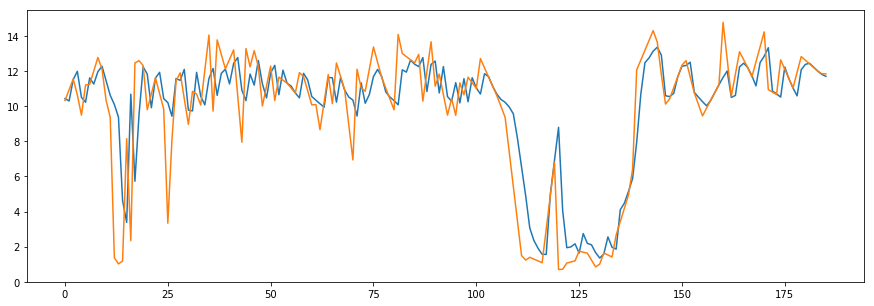

In [75]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]


plt.plot(output[:,23].detach().numpy())
plt.plot(target[:,23].detach().numpy())

###### 